In [17]:
# Cell 1: Imports
import os
import pandas as pd
import numpy as np
import joblib
from tqdm.notebook import tqdm

# --- Core ML Libraries ---
from sklearn.model_selection import GridSearchCV, GroupKFold, ParameterGrid, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# --- SMOTE for Resampling ---
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline # Use imblearn's special pipeline

# --- Metrics ---
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

print("All libraries imported successfully.")

All libraries imported successfully.


In [18]:
# Cell 2: Load Your Dataset

# --- IMPORTANT: Make sure this is the correct path to your dataset ---
DATASET_PATH = "../poc_dataset_2.csv"

if os.path.exists(DATASET_PATH):
    df = pd.read_csv(DATASET_PATH)
    print(f"Successfully loaded '{DATASET_PATH}' with {len(df)} frames from {len(df['patient_id'].unique())} patients.")
else:
    print(f"FATAL ERROR: Dataset '{DATASET_PATH}' not found. Please create it first.")
    df = pd.DataFrame() # Create empty dataframe to prevent further errors

if not df.empty:
  # Prepare data for the model
  X = df.drop(columns=['patient_id', 'label'])
  y = df['label']
  groups = df['patient_id'] # This is crucial for GroupKFold

  print("\nData prepared for training.")

Successfully loaded '../poc_dataset_2.csv' with 342722 frames from 20 patients.

Data prepared for training.


In [19]:
# Cell 3: Define the SMOTE Pipeline and a SMARTER Randomized Search (Corrected)

from sklearn.model_selection import RandomizedSearchCV # Import RandomizedSearchCV

# --- 1. Define the Cross-Validation Strategy ---
cv_strategy = GroupKFold(n_splits=5)

# --- 2. Define the SMOTE-based Pipeline ---
# This remains the same as our last corrected version.
smote_pipeline = ImbPipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42, n_jobs=-1))
])

# --- 3. Define the Hyperparameter DISTRIBUTION ---
# For RandomizedSearch, we define a distribution of options to sample from.
# The grid is much smaller and more focused now.
param_dist = {
    'smote__sampling_strategy': [0.75, 1.0],
    'smote__k_neighbors': [5, 7],
    'classifier__n_estimators': [250], # Focus on one good estimator value
    'classifier__max_depth': [25, 35, None],
    'classifier__min_samples_leaf': [1, 3]
}

print("SMOTE pipeline and hyperparameter distribution are defined for a faster Randomized Search.")

SMOTE pipeline and hyperparameter distribution are defined for a faster Randomized Search.


In [20]:
# Cell 4: Run a Faster Randomized Search

from sklearn.model_selection import RandomizedSearchCV

if not df.empty:
    # --- Set up RandomizedSearchCV ---
    # This is the key change. Instead of trying every combination, it will
    # randomly sample a fixed number of combinations ('n_iter').
    random_search_smote = RandomizedSearchCV(
        estimator=smote_pipeline,
        param_distributions=param_dist,
        n_iter=8,  # <-- CRITICAL: We will only test 8 random combinations!
        cv=cv_strategy,
        scoring='f1_weighted',
        n_jobs=-1,
        verbose=2, # Set verbose=2 to see real-time progress this time
        random_state=42
    )

    # Calculate total fits for context
    total_fits = 8 * cv_strategy.get_n_splits(X, y, groups)
    print(f"\n--- Starting RandomizedSearchCV with SMOTE ---")
    print(f"This will perform a maximum of {total_fits} fits. This should be MUCH faster.")

    # Run the search. The `verbose=2` will print progress for each fit.
    random_search_smote.fit(X, y, groups=groups)

    print("\n--- Training Complete! ---")

    # Store the results
    best_smote_score = random_search_smote.best_score_
    best_smote_params = random_search_smote.best_params_
    best_smote_model = random_search_smote.best_estimator_

    print("\n--- Randomized Search Best Results ---")
    print(f"Best cross-validation F1-score (weighted): {best_smote_score:.4f}")
    print("\nBest Parameters Found (from the random sample):")
    print(best_smote_params)

    # --- Save the best model to a file ---
    model_filename = 'best_smote_randomforest_model_randomized.pkl'
    joblib.dump(best_smote_model, model_filename)
    print(f"\nBest trained model saved to '{model_filename}'")

else:
    print("Skipping training because the dataset was not loaded.")


--- Starting RandomizedSearchCV with SMOTE ---
This will perform a maximum of 40 fits. This should be MUCH faster.
Fitting 5 folds for each of 8 candidates, totalling 40 fits

--- Training Complete! ---

--- Randomized Search Best Results ---
Best cross-validation F1-score (weighted): 0.6193

Best Parameters Found (from the random sample):
{'smote__sampling_strategy': 0.75, 'smote__k_neighbors': 5, 'classifier__n_estimators': 250, 'classifier__min_samples_leaf': 1, 'classifier__max_depth': None}

Best trained model saved to 'best_smote_randomforest_model_randomized.pkl'



--- Final Validation of SMOTE Model on a Hold-Out Test Set ---
Evaluating the best model on the unseen test set...

--- Test Set Performance ---
              precision    recall  f1-score   support

    No Apnea       1.00      1.00      1.00     34124
       Apnea       1.00      1.00      1.00     34603

    accuracy                           1.00     68727
   macro avg       1.00      1.00      1.00     68727
weighted avg       1.00      1.00      1.00     68727



NameError: name 'plt' is not defined

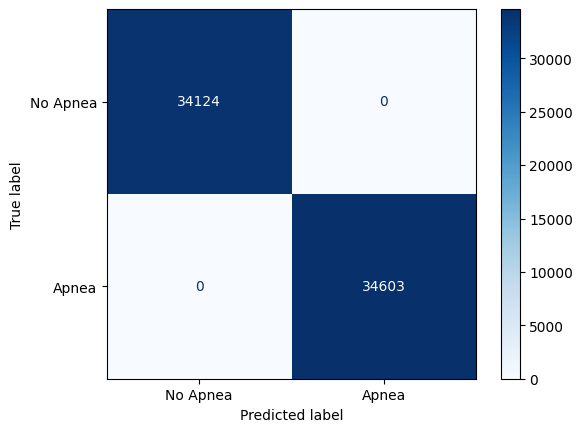

In [21]:
# Cell 5: Final Validation on a Test Set

if not df.empty and 'best_smote_model' in locals():
    print("\n--- Final Validation of SMOTE Model on a Hold-Out Test Set ---")
    
    # Create a single, representative train/test split based on patient groups
    train_indices, test_indices = next(GroupKFold(n_splits=5).split(X, y, groups=groups))

    X_train, X_test = X.iloc[train_indices], X.iloc[test_indices]
    y_train, y_test = y.iloc[train_indices], y.iloc[test_indices]
    
    # You can either re-train the model with the best params, or use the 'best_estimator_'
    # which is already trained on the full dataset during the final phase of GridSearchCV.
    # For simplicity, we will use the already-trained best_estimator_ to make predictions.
    
    print("Evaluating the best model on the unseen test set...")
    y_pred = best_smote_model.predict(X_test)

    print("\n--- Test Set Performance ---")
    # Using target_names makes the report easier to read
    print(classification_report(y_test, y_pred, target_names=['No Apnea', 'Apnea']))

    # Display the confusion matrix
    ConfusionMatrixDisplay.from_estimator(
        best_smote_model,
        X_test,
        y_test,
        display_labels=['No Apnea', 'Apnea'],
        cmap='Blues'
    )
    plt.title('Confusion Matrix for Best SMOTE Model')
    plt.show()

else:
    print("Skipping final validation because the model was not trained.")

In [ ]:
# Cell 6: Hyperparameter Tuning

print("\n--- Hyperparameter Tuning (GridSearchCV with GroupKFold) ---")

# Define parameter grid for the Random Forest Classifier
param_grid = {
    'classifier__n_estimators': [100, 200], # Number of trees in the forest
    'classifier__max_depth': [10, 20, None], # Max depth of trees (None means unlimited)
    'classifier__min_samples_split': [2, 5], # Min number of samples required to split an internal node
    'smote__sampling_strategy': ['auto', 0.5, 0.75] # SMOTE's sampling strategy
}

# For XGBoost, an example param_grid might look like:
# param_grid = {
#     'classifier__n_estimators': [100, 200],
#     'classifier__max_depth': [3, 5],
#     'classifier__learning_rate': [0.05, 0.1],
#     'smote__sampling_strategy': ['auto', 0.5, 0.75]
# }


# Use GroupKFold for cross-validation to ensure patient data stays together
# We use patient_ids_train to define groups within the training set.
cv = GroupKFold(n_splits=3) # Use 3 or 5 splits for quicker initial tuning

# Perform Grid Search
# 'scoring' is crucial for imbalanced datasets; 'f1' or 'roc_auc' are good choices for binary classification.
grid_search = GridSearchCV(
    pipeline,
    param_grid,
    cv=cv,
    scoring='f1', # Optimize for F1-score, which balances precision and recall
    n_jobs=-1,    # Use all available cores
    verbose=2,    # Show progress
    error_score='raise' # Raise an error if any parameter combination fails
)

print(f"Starting Grid Search with {cv.n_splits} folds...")
grid_search.fit(X_train, y_train, groups=patient_ids_train) # Pass groups for GroupKFold

# Get the best model
best_model = grid_search.best_estimator_

print("\n--- Grid Search Results ---")
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")


--- Hyperparameter Tuning (GridSearchCV with GroupKFold) ---
Starting Grid Search with 3 folds...
Fitting 3 folds for each of 36 candidates, totalling 108 fits

--- Grid Search Results ---
Best parameters found: {'classifier__max_depth': 10, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 200, 'smote__sampling_strategy': 'auto'}
Best cross-validation F1-score: 0.2453



--- Model Evaluation on Test Set ---
Accuracy: 0.7433
Precision: 0.1787
Recall: 0.3654
F1-Score: 0.2400
ROC AUC: 0.6004

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.79      0.85     54608
           1       0.18      0.37      0.24      6815

    accuracy                           0.74     61423
   macro avg       0.54      0.58      0.54     61423
weighted avg       0.83      0.74      0.78     61423


Confusion Matrix:


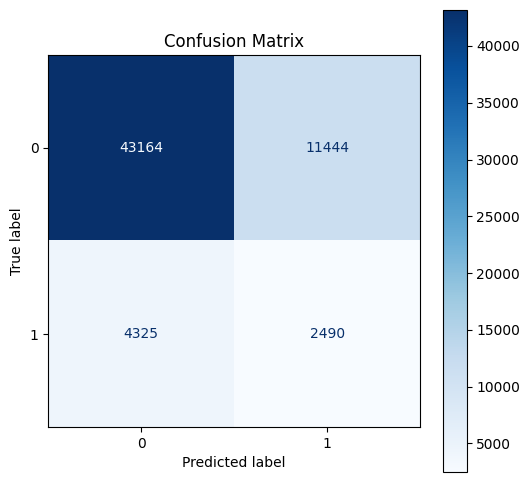


ROC Curve:


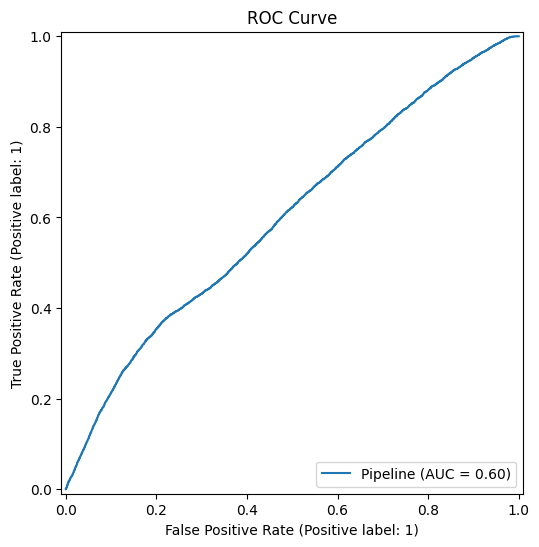


Precision-Recall Curve:


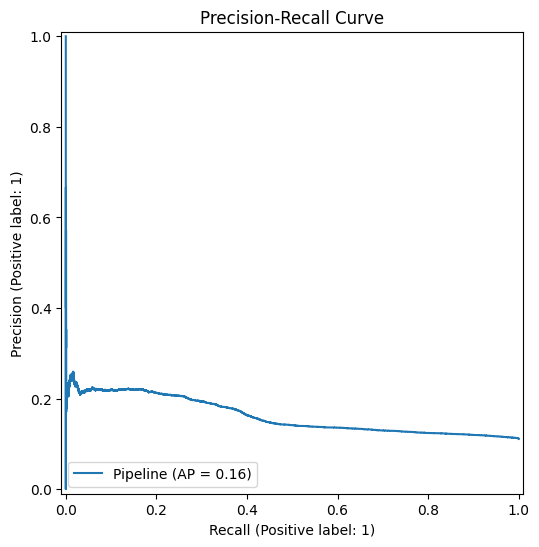

In [ ]:
# Cell 7: Model Evaluation

print("\n--- Model Evaluation on Test Set ---")

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1] # Probability of the positive class (apnea)

# Print classification metrics
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.4f}")

# Print detailed classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Plot Confusion Matrix
print("\nConfusion Matrix:")
fig, ax = plt.subplots(figsize=(6, 6))
cm_display = ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

# Plot ROC Curve
print("\nROC Curve:")
fig, ax = plt.subplots(figsize=(6, 6))
roc_display = RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
plt.title("ROC Curve")
plt.show()

# Plot Precision-Recall Curve (often more informative for imbalanced data)
print("\nPrecision-Recall Curve:")
fig, ax = plt.subplots(figsize=(6, 6))
pr_display = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=ax)
plt.title("Precision-Recall Curve")
plt.show()

In [ ]:
# Cell 8: Model Saving (Optional)

model_filename = 'apnea_detection_model.pkl'
try:
    joblib.dump(best_model, model_filename)
    print(f"\nModel saved successfully as '{model_filename}'")
except Exception as e:
    print(f"Error saving model: {e}")

# Example of how to load the model later:
# loaded_model = joblib.load(model_filename)
# print(f"Model loaded successfully from '{model_filename}'")


Model saved successfully as 'apnea_detection_model.pkl'


--- Investigating Feature Distributions for Class 0 vs. Class 1 ---


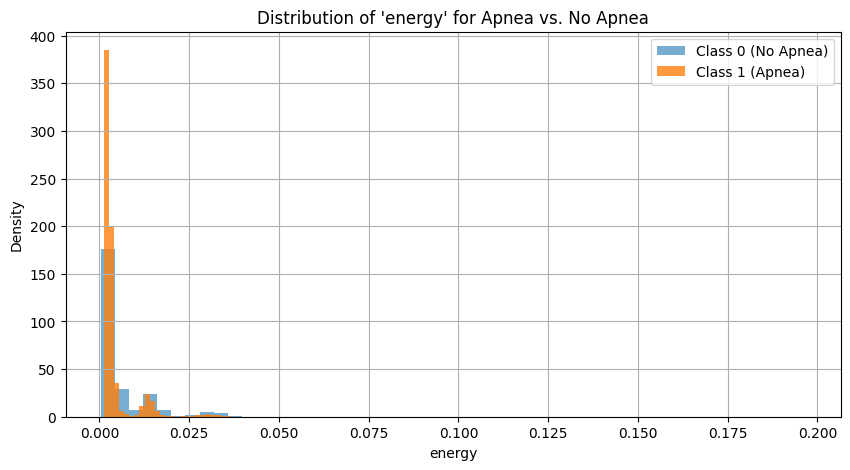

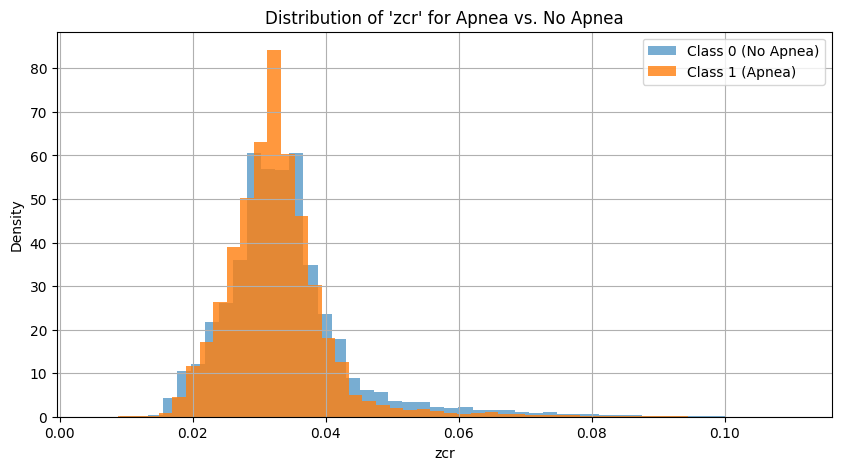

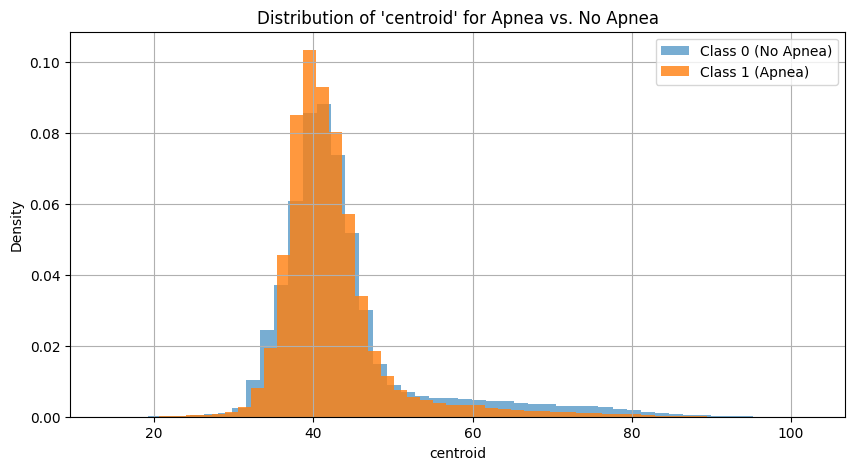

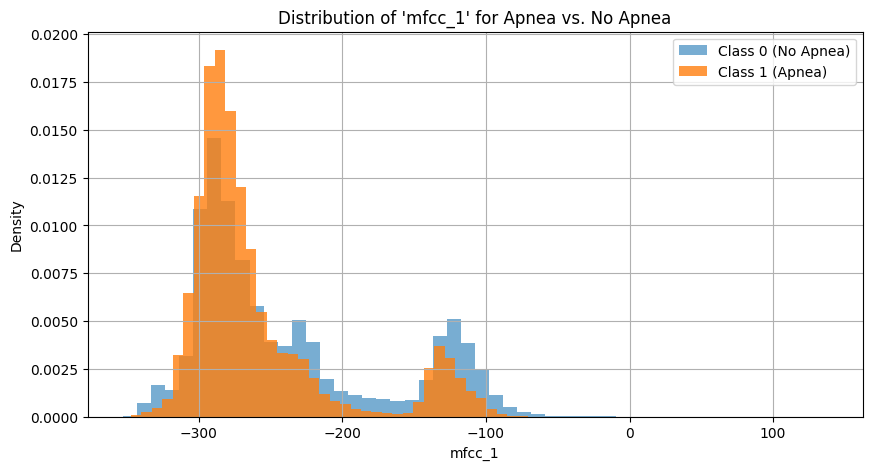

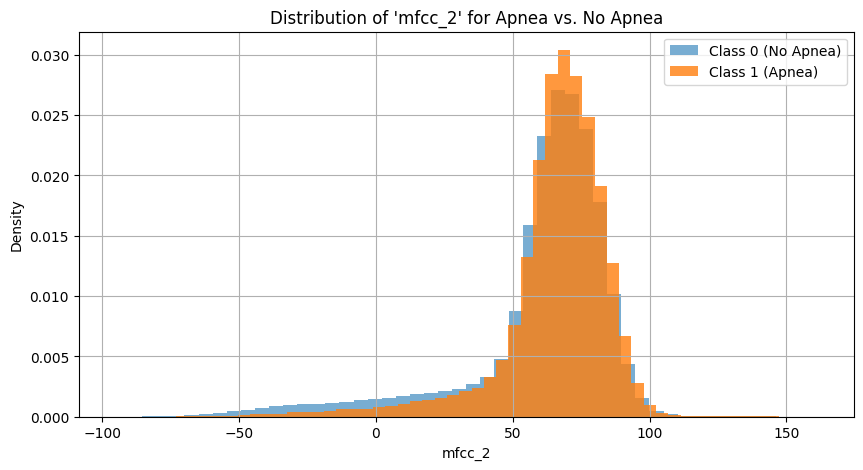

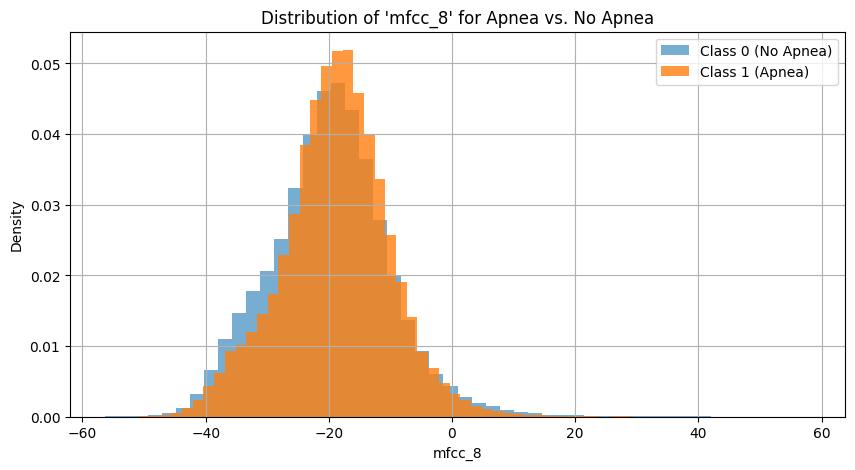

In [ ]:
# New Cell 1: Visual Sanity Check - Are the classes different at all?

print("--- Investigating Feature Distributions for Class 0 vs. Class 1 ---")

# Let's select a few key features to compare
features_to_check = ['energy', 'zcr', 'centroid', 'mfcc_1', 'mfcc_2', 'mfcc_8']
df_cleaned = X.join(y) # Temporarily join features and labels for easy plotting

# Create histograms for each feature, split by the 'label'
for feature in features_to_check:
    plt.figure(figsize=(10, 5))
    # Plot histogram for Class 0 (No Apnea)
    df_cleaned[df_cleaned['label'] == 0][feature].hist(bins=50, alpha=0.6, label='Class 0 (No Apnea)', density=True)
    # Plot histogram for Class 1 (Apnea)
    df_cleaned[df_cleaned['label'] == 1][feature].hist(bins=50, alpha=0.8, label='Class 1 (Apnea)', density=True)

    plt.title(f"Distribution of '{feature}' for Apnea vs. No Apnea")
    plt.xlabel(feature)
    plt.ylabel("Density")
    plt.legend()
    plt.show()


--- Training a Single Decision Stump (max_depth=1) ---
--- Evaluation of the Simplest Model ---
              precision    recall  f1-score   support

           0       0.92      0.73      0.82     54608
           1       0.18      0.46      0.26      6815

    accuracy                           0.70     61423
   macro avg       0.55      0.60      0.54     61423
weighted avg       0.83      0.70      0.75     61423



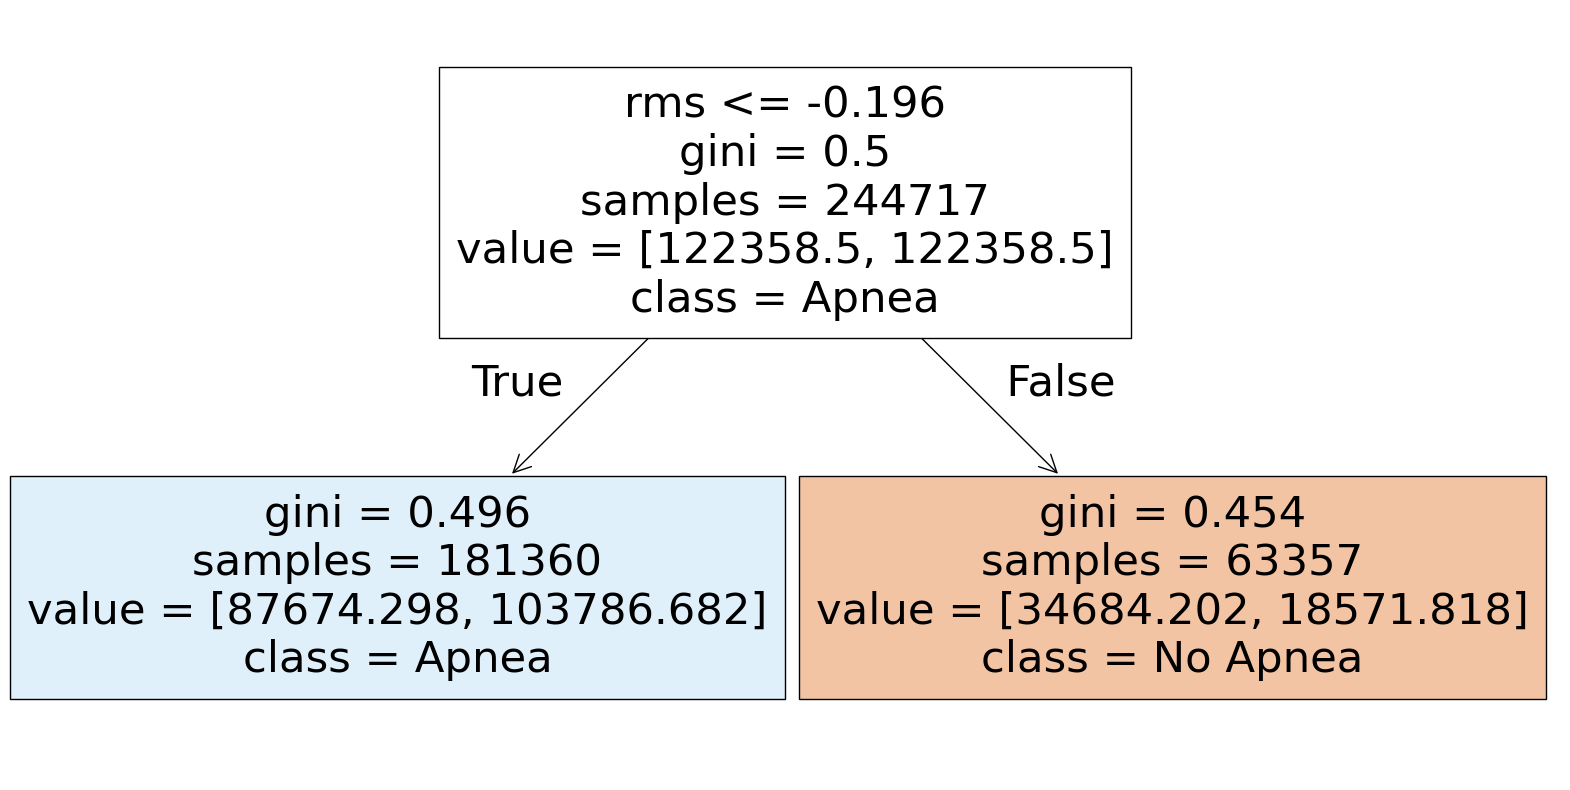

In [ ]:
# New Cell 2: The Simplest Model Imaginable
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.pipeline import Pipeline 

print("\n--- Training a Single Decision Stump (max_depth=1) ---")

# Use a simple pipeline without any complex resampling
simple_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', DecisionTreeClassifier(max_depth=1, class_weight='balanced')) # A single decision!
])

simple_pipeline.fit(X_train, y_train)
y_pred_simple = simple_pipeline.predict(X_test)

print("--- Evaluation of the Simplest Model ---")
print(classification_report(y_test, y_pred_simple))

# Let's visualize the one rule it learned
plt.figure(figsize=(20, 10))
plot_tree(simple_pipeline.named_steps['classifier'], feature_names=features, class_names=['No Apnea', 'Apnea'], filled=True)
plt.show()